## **Pytorch on MNIST hand written recognition data set**

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker.

In [1]:
import torch
import torchvision
from typing import Optional

we'll define the hyperparameters we'll be using for the experiment. Here the number of epochs defines how many times we'll loop over the complete training dataset, while learning_rate and momentum are hyperparameters for the optimizer we'll be using later on.

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Basic variables created by Zayd Hammoudeh for use in the tool

In [3]:
data_dir = "~/.data/"
num_classes = 10

We'll also need DataLoaders for the dataset. This is where TorchVision comes into play. It lets us load the MNIST dataset in a handy way. We'll use a batch_size of 64 for training and size 1000 for testing on this dataset. The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(data_dir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(data_dir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size = batch_size_test, shuffle=True)

Now let's take a look at some examples. We'll use the test_loader for this.

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

So one test data batch is a tensor of shape: This means we have 1000 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). We can plot some of them using matplotlib.

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

<Figure size 640x480 with 6 Axes>

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Here's an example model. Two 2-D convolutional layers followed by two fully-connected (or linear) layers. For activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

initialize the network and the optimizer.

In [10]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

Time to build our training loop. First we want to make sure our network is in training mode. Then we iterate over all training data once per epoch. Loading the individual batches is handled by the DataLoader. First we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The backward() call collects a new set of gradients which we propagate back into each of the network's parameters using optimizer.step(). For more detailed information about the inner workings of PyTorch's automatic gradient system, see the official docs for autograd.

In [11]:
# utility containers to record how training process goes, used for later visulaztions
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [13]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Time to run the training! We'll manually add a test() call before we loop over n_epochs to evaluate our model with randomly initialized parameters.

In [14]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/Users/zayd/.pyenv/versions/3.7.1/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327838
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.302082
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.303369
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.241829
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264621
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.182935
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.117638
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.087862
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.086544
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.053921
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.982881
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.814940
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.870628
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.793781
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.487323
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.470562
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.496524
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.413974
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.485131
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.304322
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.472800
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.590632
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.296907
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.340803
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.342513
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.452479
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.249498
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.379779
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.471339
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.503824
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.365698
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.386882
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.460157
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.377674
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.221811
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.238290
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.233775
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.634026
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.413688


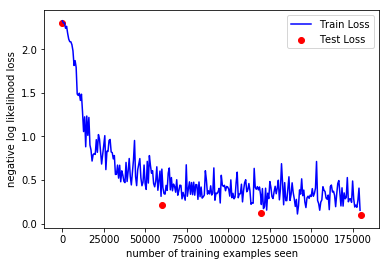

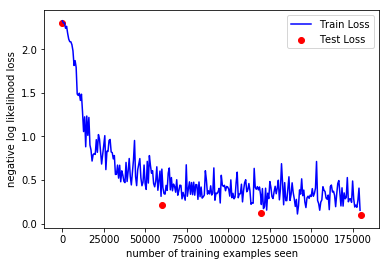

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

Class `BaseFFNoDropout` used as the base for models 3.1-3.4

In [16]:
class BaseFF(nn.Module):
    def __init__(self, hidden_dim: int, act: nn.Module, 
                 p_dropout: Optional[float] = None):
        super().__init__()
        self._module = nn.Sequential(nn.Linear(28*28, hidden_dim),
                                     act())
        if p_dropout is not None:
            self._module.add_module("Dropout", nn.Dropout(p_dropout))
        self._module.add_module("Out_Lin", nn.Linear(hidden_dim, num_classes))
        self._module.add_module("Softmax", nn.Softmax(dim=1))

    def forward(self, x):
        y = x.view(-1, 28 * 28)
        return self._module(y)

`train_test_report` is used to standardize training, testing, and reporting of the results for each of the seven networks.

In [17]:
def train_test_report():
    global optimizer
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

    # utility containers to record how training process goes, used for later visulaztions
    global train_losses, train_counter, test_losses, test_counter
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()

    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

Class `Prob3p1` is the network used for part 3.1 of the homework.


Test set: Avg. loss: -0.1023, Accuracy: 1028/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.102820
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.115442
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.100168
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.105169
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.110539
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.105402
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.111180
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.110200
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.118274
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.101500
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.113184
Train Epoch: 1 [7040/60000 (12%)]	Loss: -0.105793
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.103557
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.106219
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.106767
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.110820
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.110523
Train Epoch: 1 [10880/60000 (18%)]	Loss: -0.129754
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.114517
T

Train Epoch: 2 [42240/60000 (70%)]	Loss: -0.215190
Train Epoch: 2 [42880/60000 (71%)]	Loss: -0.203455
Train Epoch: 2 [43520/60000 (72%)]	Loss: -0.251321
Train Epoch: 2 [44160/60000 (74%)]	Loss: -0.202041
Train Epoch: 2 [44800/60000 (75%)]	Loss: -0.184345
Train Epoch: 2 [45440/60000 (76%)]	Loss: -0.202129
Train Epoch: 2 [46080/60000 (77%)]	Loss: -0.228633
Train Epoch: 2 [46720/60000 (78%)]	Loss: -0.234102
Train Epoch: 2 [47360/60000 (79%)]	Loss: -0.266988
Train Epoch: 2 [48000/60000 (80%)]	Loss: -0.279541
Train Epoch: 2 [48640/60000 (81%)]	Loss: -0.208745
Train Epoch: 2 [49280/60000 (82%)]	Loss: -0.250410
Train Epoch: 2 [49920/60000 (83%)]	Loss: -0.251310
Train Epoch: 2 [50560/60000 (84%)]	Loss: -0.221380
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.182490
Train Epoch: 2 [51840/60000 (86%)]	Loss: -0.203468
Train Epoch: 2 [52480/60000 (87%)]	Loss: -0.201636
Train Epoch: 2 [53120/60000 (88%)]	Loss: -0.196488
Train Epoch: 2 [53760/60000 (90%)]	Loss: -0.197920
Train Epoch: 2 [54400/60000 (91

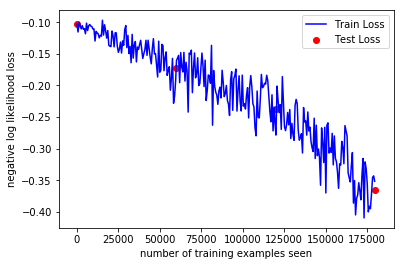

In [18]:
class Prob3p1(BaseFF):
    def __init__(self):
        super().__init__(16, nn.Sigmoid)

network = Prob3p1()
train_test_report()

Class `Prob3p2` is the network used for part 3.2 of the homework.


Test set: Avg. loss: -0.0994, Accuracy: 991/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.095260
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.098399
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.103483
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.098031
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.096084
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.109446
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.097127
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.101249
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.099033
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.092424
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.108969
Train Epoch: 1 [7040/60000 (12%)]	Loss: -0.095237
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.106269
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.102784
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.099665
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.100768
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.105599
Train Epoch: 1 [10880/60000 (18%)]	Loss: -0.098497
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.108932
Tra

Train Epoch: 2 [42240/60000 (70%)]	Loss: -0.394523
Train Epoch: 2 [42880/60000 (71%)]	Loss: -0.393013
Train Epoch: 2 [43520/60000 (72%)]	Loss: -0.330771
Train Epoch: 2 [44160/60000 (74%)]	Loss: -0.409891
Train Epoch: 2 [44800/60000 (75%)]	Loss: -0.378203
Train Epoch: 2 [45440/60000 (76%)]	Loss: -0.447098
Train Epoch: 2 [46080/60000 (77%)]	Loss: -0.474898
Train Epoch: 2 [46720/60000 (78%)]	Loss: -0.463467
Train Epoch: 2 [47360/60000 (79%)]	Loss: -0.431483
Train Epoch: 2 [48000/60000 (80%)]	Loss: -0.383626
Train Epoch: 2 [48640/60000 (81%)]	Loss: -0.396451
Train Epoch: 2 [49280/60000 (82%)]	Loss: -0.403093
Train Epoch: 2 [49920/60000 (83%)]	Loss: -0.397361
Train Epoch: 2 [50560/60000 (84%)]	Loss: -0.380943
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.427235
Train Epoch: 2 [51840/60000 (86%)]	Loss: -0.383961
Train Epoch: 2 [52480/60000 (87%)]	Loss: -0.353479
Train Epoch: 2 [53120/60000 (88%)]	Loss: -0.361764
Train Epoch: 2 [53760/60000 (90%)]	Loss: -0.427976
Train Epoch: 2 [54400/60000 (91

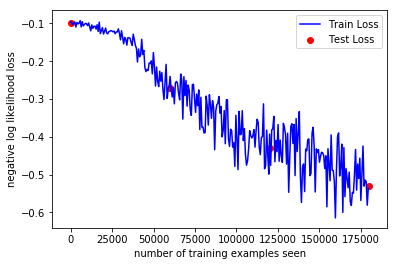

In [19]:
class Prob3p2(BaseFF):
    def __init__(self):
        super().__init__(128, nn.Sigmoid)
        
        
network = Prob3p2()
train_test_report()

Class `Prob3p3` is the network used for part 3.3 of the homework.


Test set: Avg. loss: -0.1035, Accuracy: 1304/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.098639
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.104185
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.104520
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.113075
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.114498
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.118322
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.126160
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.141218
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.144895
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.149347
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.146353
Train Epoch: 1 [7040/60000 (12%)]	Loss: -0.151756
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.164464
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.207004
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.172376
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.201571
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.248487
Train Epoch: 1 [10880/60000 (18%)]	Loss: -0.265427
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.306584
T

Train Epoch: 2 [42240/60000 (70%)]	Loss: -0.863349
Train Epoch: 2 [42880/60000 (71%)]	Loss: -0.881984
Train Epoch: 2 [43520/60000 (72%)]	Loss: -0.831617
Train Epoch: 2 [44160/60000 (74%)]	Loss: -0.866499
Train Epoch: 2 [44800/60000 (75%)]	Loss: -0.852137
Train Epoch: 2 [45440/60000 (76%)]	Loss: -0.885993
Train Epoch: 2 [46080/60000 (77%)]	Loss: -0.872507
Train Epoch: 2 [46720/60000 (78%)]	Loss: -0.814537
Train Epoch: 2 [47360/60000 (79%)]	Loss: -0.847176
Train Epoch: 2 [48000/60000 (80%)]	Loss: -0.896122
Train Epoch: 2 [48640/60000 (81%)]	Loss: -0.868827
Train Epoch: 2 [49280/60000 (82%)]	Loss: -0.842566
Train Epoch: 2 [49920/60000 (83%)]	Loss: -0.801954
Train Epoch: 2 [50560/60000 (84%)]	Loss: -0.795515
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.868553
Train Epoch: 2 [51840/60000 (86%)]	Loss: -0.826372
Train Epoch: 2 [52480/60000 (87%)]	Loss: -0.844135
Train Epoch: 2 [53120/60000 (88%)]	Loss: -0.817214
Train Epoch: 2 [53760/60000 (90%)]	Loss: -0.837018
Train Epoch: 2 [54400/60000 (91

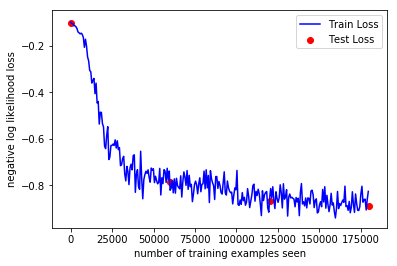

In [20]:
class Prob3p3(BaseFF):
    def __init__(self):
        super().__init__(128, nn.ReLU)


network = Prob3p3()
train_test_report()

Class `Prob3p4` is the network used for part 3.4 of the homework.


Test set: Avg. loss: -0.1007, Accuracy: 994/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.098067
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.107245
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.104890
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.116512
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.112670
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.117891
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.123366
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.137389
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.149020
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.166561
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.165842
Train Epoch: 1 [7040/60000 (12%)]	Loss: -0.201240
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.228229
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.209314
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.201873
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.233090
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.268384
Train Epoch: 1 [10880/60000 (18%)]	Loss: -0.248896
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.268739
Tra

Train Epoch: 2 [42880/60000 (71%)]	Loss: -0.768310
Train Epoch: 2 [43520/60000 (72%)]	Loss: -0.743685
Train Epoch: 2 [44160/60000 (74%)]	Loss: -0.747048
Train Epoch: 2 [44800/60000 (75%)]	Loss: -0.824047
Train Epoch: 2 [45440/60000 (76%)]	Loss: -0.752308
Train Epoch: 2 [46080/60000 (77%)]	Loss: -0.643141
Train Epoch: 2 [46720/60000 (78%)]	Loss: -0.750171
Train Epoch: 2 [47360/60000 (79%)]	Loss: -0.734804
Train Epoch: 2 [48000/60000 (80%)]	Loss: -0.747181
Train Epoch: 2 [48640/60000 (81%)]	Loss: -0.781726
Train Epoch: 2 [49280/60000 (82%)]	Loss: -0.803259
Train Epoch: 2 [49920/60000 (83%)]	Loss: -0.833005
Train Epoch: 2 [50560/60000 (84%)]	Loss: -0.644371
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.719981
Train Epoch: 2 [51840/60000 (86%)]	Loss: -0.779853
Train Epoch: 2 [52480/60000 (87%)]	Loss: -0.811135
Train Epoch: 2 [53120/60000 (88%)]	Loss: -0.799517
Train Epoch: 2 [53760/60000 (90%)]	Loss: -0.792351
Train Epoch: 2 [54400/60000 (91%)]	Loss: -0.735243
Train Epoch: 2 [55040/60000 (92

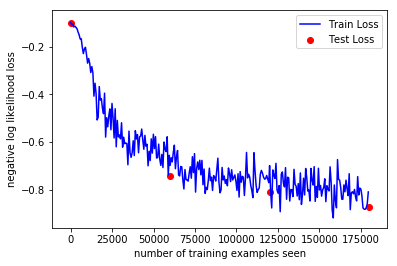

In [21]:
class Prob3p4(BaseFF):
    def __init__(self):
        super().__init__(128, nn.ReLU, 0.5)


network = Prob3p4()
train_test_report()

Class `BaseConv` used as the base for models 3.5-3.7

In [22]:
class BaseConv(nn.Module):
    def __init__(self, inc_pool: bool = False, inc_sec_conv: bool = False):
        super().__init__()
        self._conv = nn.Sequential(nn.Conv2d(1, 10, kernel_size=5),
                                   nn.ReLU())
        self._conv_out_dim = 5760
                 
        if inc_sec_conv:
            self._conv.add_module("pool1", nn.MaxPool2d(kernel_size=2))
            self._conv.add_module("Conv2", nn.Conv2d(10, 20, kernel_size=5))
            self._conv.add_module("Conv2ReLU", nn.ReLU())
            self._conv_out_dim = 320
        if inc_pool or inc_sec_conv:
            self._conv.add_module("dropout_out", nn.Dropout2d())
            self._conv.add_module("pool_out", nn.MaxPool2d(kernel_size=2))
            if not inc_sec_conv: self._conv_out_dim = 1440
            
        # All three networks have the same output structure of 128 ReLUs with
        # 50% dropout
        hidden_dim, p_dropout = 128, 0.5
        self._module = nn.Sequential(nn.Linear(self._conv_out_dim, hidden_dim), 
                                     nn.ReLU(),  
                                     nn.Dropout(p_dropout),  
                                     nn.Linear(hidden_dim, num_classes),
                                     nn.Softmax(dim=1))

    def forward(self, x):
        y = self._conv(x)
        y = y.view(-1, self._conv_out_dim)
        return self._module(y)

Class `Prob3p5` is the network used for part 3.5 of the homework.


Test set: Avg. loss: -0.1003, Accuracy: 1076/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.101378
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.102873
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.105357
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.113306
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.113143
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.115179
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.128425
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.137620
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.168684
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.214725
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.189781
Train Epoch: 1 [7040/60000 (12%)]	Loss: -0.217354
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.306115
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.316850
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.393919
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.412630
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.551348
Train Epoch: 1 [10880/60000 (18%)]	Loss: -0.559933
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.576607
T

Train Epoch: 2 [42240/60000 (70%)]	Loss: -0.827088
Train Epoch: 2 [42880/60000 (71%)]	Loss: -0.905206
Train Epoch: 2 [43520/60000 (72%)]	Loss: -0.813227
Train Epoch: 2 [44160/60000 (74%)]	Loss: -0.799583
Train Epoch: 2 [44800/60000 (75%)]	Loss: -0.827706
Train Epoch: 2 [45440/60000 (76%)]	Loss: -0.845002
Train Epoch: 2 [46080/60000 (77%)]	Loss: -0.857814
Train Epoch: 2 [46720/60000 (78%)]	Loss: -0.809753
Train Epoch: 2 [47360/60000 (79%)]	Loss: -0.777900
Train Epoch: 2 [48000/60000 (80%)]	Loss: -0.816858
Train Epoch: 2 [48640/60000 (81%)]	Loss: -0.765201
Train Epoch: 2 [49280/60000 (82%)]	Loss: -0.874334
Train Epoch: 2 [49920/60000 (83%)]	Loss: -0.775436
Train Epoch: 2 [50560/60000 (84%)]	Loss: -0.868366
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.801959
Train Epoch: 2 [51840/60000 (86%)]	Loss: -0.785200
Train Epoch: 2 [52480/60000 (87%)]	Loss: -0.809395
Train Epoch: 2 [53120/60000 (88%)]	Loss: -0.764903
Train Epoch: 2 [53760/60000 (90%)]	Loss: -0.802091
Train Epoch: 2 [54400/60000 (91

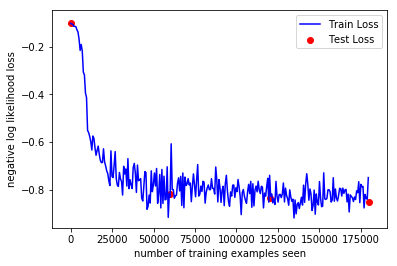

In [23]:
class Prob3p5(BaseConv):
    def __init__(self):
        super().__init__()


network = Prob3p5()
train_test_report()

Class `Prob3p6` is the network used for part 3.6 of the homework.


Test set: Avg. loss: -0.0979, Accuracy: 1174/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.095698
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.095636
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.101401
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.101137
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.103044
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.110655
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.114603
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.106632
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.122491
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.130809
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.147856
Train Epoch: 1 [7040/60000 (12%)]	Loss: -0.154417
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.152589
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.165032
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.170135
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.170348
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.216528
Train Epoch: 1 [10880/60000 (18%)]	Loss: -0.248805
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.271335
T

Train Epoch: 2 [42880/60000 (71%)]	Loss: -0.830424
Train Epoch: 2 [43520/60000 (72%)]	Loss: -0.846131
Train Epoch: 2 [44160/60000 (74%)]	Loss: -0.881760
Train Epoch: 2 [44800/60000 (75%)]	Loss: -0.850986
Train Epoch: 2 [45440/60000 (76%)]	Loss: -0.831734
Train Epoch: 2 [46080/60000 (77%)]	Loss: -0.871857
Train Epoch: 2 [46720/60000 (78%)]	Loss: -0.722162
Train Epoch: 2 [47360/60000 (79%)]	Loss: -0.732856
Train Epoch: 2 [48000/60000 (80%)]	Loss: -0.747074
Train Epoch: 2 [48640/60000 (81%)]	Loss: -0.828806
Train Epoch: 2 [49280/60000 (82%)]	Loss: -0.753852
Train Epoch: 2 [49920/60000 (83%)]	Loss: -0.773139
Train Epoch: 2 [50560/60000 (84%)]	Loss: -0.831052
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.782869
Train Epoch: 2 [51840/60000 (86%)]	Loss: -0.783967
Train Epoch: 2 [52480/60000 (87%)]	Loss: -0.749977
Train Epoch: 2 [53120/60000 (88%)]	Loss: -0.702944
Train Epoch: 2 [53760/60000 (90%)]	Loss: -0.719925
Train Epoch: 2 [54400/60000 (91%)]	Loss: -0.770615
Train Epoch: 2 [55040/60000 (92

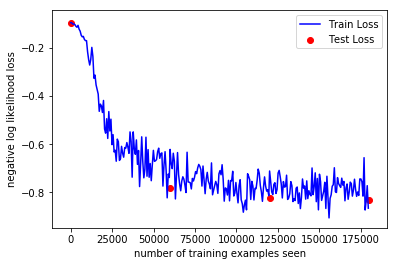

In [24]:
class Prob3p6(BaseConv):
    def __init__(self):
        super().__init__(inc_pool=True)


network = Prob3p6()
train_test_report()

Class `Prob3p7` is the network used for part 3.7 of the homework.


Test set: Avg. loss: -0.1001, Accuracy: 1401/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.100443
Train Epoch: 1 [640/60000 (1%)]	Loss: -0.102802
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.101726
Train Epoch: 1 [1920/60000 (3%)]	Loss: -0.099882
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.099626
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.102905
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.101303
Train Epoch: 1 [4480/60000 (7%)]	Loss: -0.101712
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.104152
Train Epoch: 1 [5760/60000 (10%)]	Loss: -0.102393
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.103708
Train Epoch: 1 [7040/60000 (12%)]	Loss: -0.099769
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.104079
Train Epoch: 1 [8320/60000 (14%)]	Loss: -0.103692
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.102060
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.101804
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.103135
Train Epoch: 1 [10880/60000 (18%)]	Loss: -0.105166
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.102937
T

Train Epoch: 2 [42240/60000 (70%)]	Loss: -0.748466
Train Epoch: 2 [42880/60000 (71%)]	Loss: -0.706312
Train Epoch: 2 [43520/60000 (72%)]	Loss: -0.716446
Train Epoch: 2 [44160/60000 (74%)]	Loss: -0.676152
Train Epoch: 2 [44800/60000 (75%)]	Loss: -0.760630
Train Epoch: 2 [45440/60000 (76%)]	Loss: -0.754483
Train Epoch: 2 [46080/60000 (77%)]	Loss: -0.717826
Train Epoch: 2 [46720/60000 (78%)]	Loss: -0.742229
Train Epoch: 2 [47360/60000 (79%)]	Loss: -0.701796
Train Epoch: 2 [48000/60000 (80%)]	Loss: -0.698316
Train Epoch: 2 [48640/60000 (81%)]	Loss: -0.778224
Train Epoch: 2 [49280/60000 (82%)]	Loss: -0.808987
Train Epoch: 2 [49920/60000 (83%)]	Loss: -0.785505
Train Epoch: 2 [50560/60000 (84%)]	Loss: -0.673363
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.751062
Train Epoch: 2 [51840/60000 (86%)]	Loss: -0.769144
Train Epoch: 2 [52480/60000 (87%)]	Loss: -0.799921
Train Epoch: 2 [53120/60000 (88%)]	Loss: -0.718710
Train Epoch: 2 [53760/60000 (90%)]	Loss: -0.767824
Train Epoch: 2 [54400/60000 (91

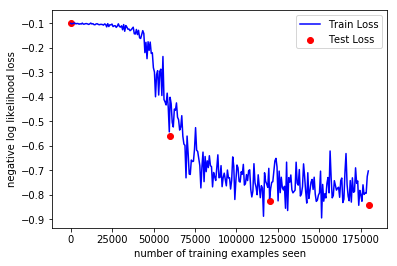

In [25]:
class Prob3p7(BaseConv):
    def __init__(self):
        super().__init__(inc_sec_conv=True)


network = Prob3p7()
train_test_report()